# A Machine Learning Model to Predict Unemployment Rate from Google Trends Data 

## Initialization

This section imports necessary packages and defines necessary parameters for development of the project. In general, packages used are `NumPy`, `Pandas`, `Scikit-Learn`, and `SciPy`. Unofficial Google Trends API `PyTrends` is used to download Google Trends data. The Department of Labor API will be used to download the unemployment rate.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import dill
from pytrends.request import TrendReq
from scipy.stats import pearsonr
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


%matplotlib notebook

## Gathering a List of Related Search Queries

This section compiles  List of related queries with unemployment from 2006 to 2021. Google keeps track of `top` and `rising` values and we'll store both. Based on previous experience, we'll also include `lunch` and `bored` as related queries. We'll later filter these queries by the absolute value of their `Pearson's r` correlation with actual unemployment records. 

In [2]:
if not os.path.exists("kw_dict.dill"):
    kw_dict={}
    for year in range(2006, 2021):
        kw_dict[year]=['lunch','bored']
        # tz=300 represents Eastern Standard Time. Do not use -300.
        pytrends = TrendReq(hl='en-US', tz=300)
        # Category 706 is 'welfare and unemployment' in Google
        pytrends.build_payload(['unemployment'], cat=706, timeframe=f'{year}-01-01 {year}-12-31', geo='US', gprop='')
        for kw in list(pytrends.related_queries().values())[0]['top']['query'].values:
            if kw not in kw_dict[year]:
                kw_dict[year].append(kw)
        for kw in list(pytrends.related_queries().values())[0]['rising']['query'].values:
            if kw not in kw_dict[year]:
                kw_dict[year].append(kw)
    dill.dump(kw_dict, open("kw_dict.dill", "wb"))
kw_dict= dill.load(open("kw_dict.dill",'rb'))

As an example let's see what queries are related with unemployment in 2020. As expected we see `"covid unemployment"` and `"cares act unemployment"` as related queries.

In [3]:
print(kw_dict[2020])

['lunch', 'bored', 'unemployment login', 'unemployment benefits', 'nj unemployment', 'unemployment ohio', 'unemployment claim', 'unemployment michigan', 'unemployment texas', 'unemployment ny', 'unemployment pua', 'unemployment number', 'file unemployment', 'unemployment office', 'nys unemployment', 'nc unemployment', 'unemployment california', 'apply for unemployment', 'pandemic unemployment', 'unemployment indiana', 'unemployment 600', 'file for unemployment', 'washington unemployment', 'unemployment pa', 'unemployment oregon', 'oregon unemployment', 'my unemployment', 'covid unemployment', 'unemployment coronavirus', 'stimulus unemployment', 'stimulus', 'pandemic unemployment assistance', 'pua unemployment ohio', 'pua unemployment login', 'extra 600 unemployment', 'cares act unemployment', 'pua unemployment pa', 'pa pandemic unemployment', '600 unemployment extension', 'stimulus update', '600 a week unemployment', 'pua unemployment az', 'pua unemployment ohio login', 'unemployment e

## Obtaining Google Trends Data

### Download Function
The function below downloads the Google Trends data given the `keyword list (kw_list)`, `start_date`, and `end_date` and stores the record as a csv file. The `kw_list` argument should be a list with one search query. If multiple search queries are passed, Google will normalize the results based on the more frequently searched query.

In [4]:
def get_google_trends(kw_list, start_date, end_date, state='US', cat=0):
    outname = f'{end_date}_{kw_list[0]}.dill'
    outdir = './data/Google Trends'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    fullname = os.path.join(outdir, outname)   
    # This if-statement makes sure we won't request the records we already have. 
    if os.path.exists(fullname):
        return None
    pytrends = TrendReq(hl='en-US', tz=300)
    if state == 'US':
        geo = 'US' 
    else:
        geo = 'US-' + state
    pytrends.build_payload(kw_list, cat=cat, timeframe=start_date+' '+end_date,
                           geo=geo, gprop='')
    df = pytrends.interest_over_time()
    df = df.reindex(pd.to_datetime(df.index))
    df['YearMonth'] = pd.to_datetime(df.index.strftime('%Y-%m'))
    table = pd.pivot_table(df, index='YearMonth', values=kw_list, aggfunc=np.sum)
    # Jan 1 means end of January. If you want to change it to Jan 31, use montth = 1, days = -1 below. 
    table.index = table.index+pd.DateOffset(months=0, days=0) 
    dill.dump(table, open(fullname, 'wb'))
    return None

### Downloading Google Trends Data for Related Search Queries

The cell below downloads the Google Trends data for all queries previously collected. Related records for each year are also downloaded for 1 year before. Note sometimes Google normalizes the results based on the month with maximum frequency. Therefore we'll have to download Google Trends results for up to (and including) each month for which we are trying to predict.

In [8]:
start_date = '2006-01-01'
end_date_list = pd.date_range(start='2007-01-01', end='2020-10-31', freq='M')
for item in end_date_list:
    year = item.year
    end_date = item.strftime('%Y-%m-%d')
    kw_list = np.unique(np.hstack([kw_dict[i] for i in range(year-1, year+1)]))
    for KEYWORD in kw_list:
    # try and except is needed to avoid Key Errors
    # for example, searches for "COVID unemployment" in January 2020 will lead to KeyError
        try:
            get_google_trends([KEYWORD], start_date, end_date, state='US')
        except KeyError:
            pass

### Downloading General Records for Welfare and Unemployment Category
In addition to keeping track of certain keywords, google keeps a tally of all search queries related to `welfare and unemployment`. These records can be obtained by passing an empty string to `kw_list`. The `welfare and unemployment` can be specified by specifying `cat=706`. The cell below downloads these records.

In [9]:
start_date = '2006-01-01'
end_date_list = pd.date_range(start='2007-01-01', end='2020-10-31', freq='M')
for item in end_date_list:
    year = item.year
    end_date = item.strftime('%Y-%m-%d')
    #Passing an empty strin
    get_google_trends(kw_list=[''], 
                      start_date=start_date, 
                      end_date=end_date, 
                      state='US', 
                      cat=706)

## Obtaining Unemployment Data

### Download Function

The set of functions below download the U.S. unemployment rate from U.S. Bureau of Labor Statistics given the `state`, `start_date`, and `end_date`.

In [10]:
def get_states_links():
    df = pd.read_table('https://download.bls.gov/pub/time.series/la/la.txt', skiprows=104, nrows=52)
    i =1
    for col in df.columns:
        df.rename(columns={col:i}, inplace=True)
        i += 1
    states=df[3].to_list()
    for i in range(len(states)):
        states_abr = states[i].split(')')[-1].split('=')[0].strip()
        states[i] = states_abr
    df[3] = states
    df = df.set_index(3)
    df = df[2].str.strip()
    return df.to_dict()

def get_state_codes(): 
    df = pd.read_table('https://download.bls.gov/pub/time.series/la/la.txt', skiprows=104, nrows=52)
    i =1
    for col in df.columns:
        df.rename(columns={col:i}, inplace=True)
        i += 1
    states=df[3].to_list()
    for i in range(len(states)):
        states[i] = states[i].split(')')[-1].split('=')[0].strip()
    df['states'] = states    
    codes=df[3].to_list()
    for i in range(len(states)):
        codes[i] = codes[i].split(')')[0].split('=')[-1].strip()
    df['code'] = codes
    df.set_index('states', inplace=True)
    df = df['code']
    return df.to_dict()

def get_unemployment(state, start_date, end_date):
    outname = 'Unemployment_{}.dill'.format(end_date)
    outdir = './data/Unemployment'
    fullname = os.path.join(outdir, outname)
    if os.path.exists(fullname):
        return None
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    states_link = get_states_links()
    states_code = get_state_codes()
    if state == 'US':
        link = 'https://download.bls.gov/pub/time.series/ln/ln.data.1.AllData'
    else:
        link = 'https://download.bls.gov/pub/time.series/la/'+states_link[state]
    if state == 'US':
        mask = 'LNS14000000'
    else:
        mask = 'LASST'+str(states_code[state])+'00000000000'+'03'
    df = pd.read_table(link, delim_whitespace=True, low_memory=False)
    df = df[df['series_id']==mask]
    #offsetting
    df['YearMonth'] = (pd.to_datetime(df['year'].astype('str')+'-'+df['period'].str[1:])
                       +pd.DateOffset(months=0, days=0))
    df = df[(df['YearMonth']>=pd.to_datetime(start_date))&(df['YearMonth']<=pd.to_datetime(end_date))]
    df = df.set_index('YearMonth')
    df = pd.DataFrame(df['value'].astype('float64'))
    df.rename(columns={'value':'unemployment_rate'}, inplace=True)
    dill.dump(df, open(fullname,'wb')) 
    return df

    

### Downloading Unemployment Data

The cell below downloads monthly U.S. unemployment rate.  Unlike Google Trends, we'll store these records in 1 file.

In [11]:
start_date = '2006-01-01'
end_date = '2020-10-31'
get_unemployment(state='US', start_date=start_date, end_date=end_date)
unemp_path = f'./data/Unemployment/Unemployment_{end_date}.dill'

## Plots of Correlation

Now let's check how the a two correlated queries change with unemployment.

### Inverse Correlation

Searches for `"lunch"` appear inversely correlated with unemployment.

<IPython.core.display.Javascript object>


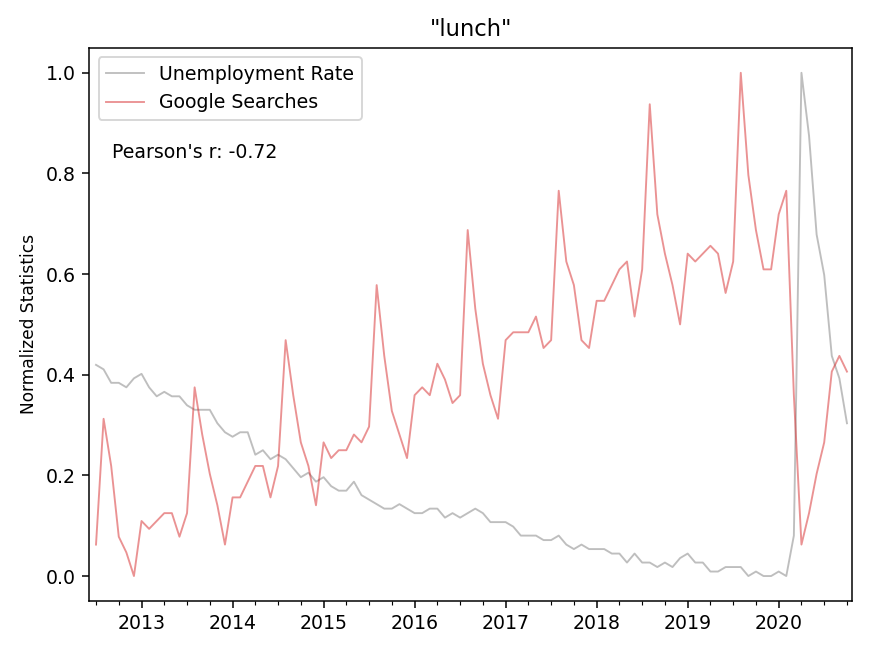

In [23]:
query = 'lunch'
srch = f'./data/Google Trends/2020-10-31_{query}.dill'
srch = dill.load(open(srch, 'rb'))
unemp = dill.load(open(unemp_path, 'rb'))
df = unemp.join(srch).iloc[-100:].copy()

def normalize(df):
    for col in df.columns:
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
        
normalize(df)

df.rename(columns={'unemployment_rate':'Unemployment Rate',
                 query: 'Google Searches'}, inplace=True)

df.plot(lw=1, alpha=.5, color=['tab:gray','tab:red'])

ax = plt.gca()
plt.ylabel('Normalized Statistics', size=9);
plt.xlabel(None)
plt.title(f'"{query}"')
plt.xlim(ax.get_xlim()[0]-0.9,ax.get_xlim()[-1]+0.7)
plt.tight_layout()
pr = round(df.corr().iloc[0,-1], 2)
ax.text(0.03,0.80, f"Pearson's r: {pr}", transform=ax.transAxes, ha='left')
plt.savefig(f'{query}.png', dpi=400)


### Direct Correlation

As expected, searches for `unemployment office` appear directly correlated with unemployment.

<IPython.core.display.Javascript object>


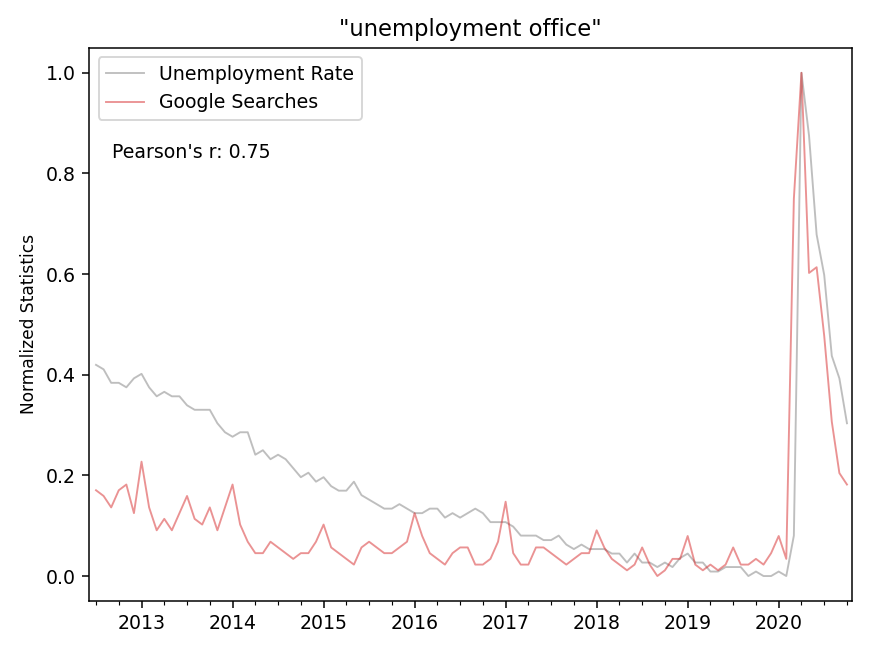

In [25]:
query = 'unemployment office'
srch = f'./data/Google Trends/2020-10-31_{query}.dill'
srch = dill.load(open(srch, 'rb'))
unemp = dill.load(open(unemp_path, 'rb'))
df = unemp.join(srch).iloc[-100:].copy()

def normalize(df):
    for col in df.columns:
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
        
normalize(df)

df.rename(columns={'unemployment_rate':'Unemployment Rate',
                 query: 'Google Searches'}, inplace=True)

df.plot(lw=1, alpha=.5, color=['tab:gray','tab:red'])

ax = plt.gca()
plt.ylabel('Normalized Statistics', size=9);
plt.xlabel(None)
plt.title(f'"{query}"')
plt.xlim(ax.get_xlim()[0]-0.9,ax.get_xlim()[-1]+0.7)
plt.tight_layout()
pr = round(df.corr().iloc[0,-1], 2)
ax.text(0.03,0.80, f"Pearson's r: {pr}", transform=ax.transAxes, ha='left')
plt.savefig(f'{query}.png', dpi=400)


## Filtering by Pearson'r R

Now that we have downloaded the unemployment records and the Google Trends Data, we'll filter the search queries and only keep those that are directly or inversly related to unemployment by a minimum Pearson's R threshold (`abs(pearsons_r)>=threshold`). For each prediction month, we'll start at 24 months back and move forward up to but not including the month we wish to predict and compare search queries with unemployment records. We'll then filter queries that have a Pearson's R value of at least 0.5 (`abs(pearsons_r)>=0.5`). 

In [14]:
unemp_path = f'./data/Unemployment/Unemployment_{end_date}.dill'
end_date_list = pd.date_range(start='2007-12-31', end='2020-10-31', freq='M')
directory = './data/Google Trends'
relev_dict = {}
for item in end_date_list:
    unemp = dill.load(open(unemp_path, 'rb'))
    unemp = unemp[(unemp.index<end_date)&(unemp.index>=pd.to_datetime(end_date)+pd.DateOffset(years=-2))]
    end_date = item.strftime('%Y-%m-%d')
    relev_dict[end_date] = []
    for file in os.listdir(directory):
        if file.startswith(end_date) and file.endswith('.dill'):
            path = directory+'/'+file
            srch = dill.load(open(path, 'rb'))
            temp = unemp.join(srch, how='inner')
            #normalize(temp)
            if abs(temp.corr().iloc[0,-1]) > 0.5:
                relev_dict[end_date].append(file)
dill.dump(relev_dict, open('relev_dict.dill','wb'))

### Queries for June 2020 having Pearson's R over the Threshold
Let's see what search queries pass this filter for June 2020. As expected, the queries are mostly pandemic-related.

In [15]:
print([file[11:-5] for file in relev_dict['2020-06-30']])

['pandemic unemployment assistance pa', 'michigan unemployment', 'pa unemployment', 'unemployment texas', 'stimulus unemployment', 'my unemployment wi', 'texas unemployment phone number', 'unemployment benefits', 'iowa unemployment claim', '', 'oregon unemployment', 'alabama unemployment tracker', 'pua unemployment ohio', 'twc unemployment', 'ct unemployment claims', 'unemployment nc', 'how to apply for unemployment in florida', 'texas unemployment office', '600 unemployment extension', 'lunch', 'unemployment stimulus', 'unemployment claim login', 'twc unemployment login', 'unemployment office', 'pandemic unemployment assistance ny', 'pua unemployment california', 'unemployment extension', 'texas unemployment', 'edd unemployment ca', 'file unemployment', 'unemployment pua', 'michigan unemployment office', 'wv unemployment', 'apply for unemployment', 'bored', '600 a week unemployment', 'who can collect unemployment', 'unemployment claim', 'pua ohio unemployment', 'pandemic unemployment'

### Number of Related Search Queries Remaining for Each Month

Let's see how many related search queries each month has after we have applied the Pearson's R filter. We can see some months have over a hundred queries but some have only a few. 

In [16]:
#to save space, we'll show the first 20
print(*[f'{key[0:7]} -> {len(value)}' for key, value in relev_dict.items()][:20], sep='\n')

2007-12 -> 0
2008-01 -> 3
2008-02 -> 4
2008-03 -> 15
2008-04 -> 25
2008-05 -> 27
2008-06 -> 23
2008-07 -> 39
2008-08 -> 44
2008-09 -> 57
2008-10 -> 64
2008-11 -> 73
2008-12 -> 92
2009-01 -> 99
2009-02 -> 107
2009-03 -> 103
2009-04 -> 107
2009-05 -> 106
2009-06 -> 110
2009-07 -> 111


#### Keeping Months that have at least 3 related Search Queries Remaining

Now let's go ahead and only keep months that have at least 3 related search queries remaining.

In [17]:
#use .copy() method in for loop so we can update the original dictionary
for key, value in relev_dict.copy().items():
    if len(value)<3:
        del relev_dict[key]

## Setting up `X` and `y`

Now let's gather DataFrames of `X` and `y` and store them as `dill` files. Our `X` DataFrames will consist of Google Trends data and our `y` DataFrames will consist of our unemployment records.

In [18]:
from functools import reduce
for key, value in relev_dict.items():
    outdir_X, outdir_y = './data/X', './data/y'
    outname_X, outname_y = f'{key}_X.dill', f'{key}_y.dill'
    fullname_X = os.path.join(outdir_X, outname_X)
    fullname_y = os.path.join(outdir_y, outname_y)
    if os.path.exists(fullname_X) and os.path.exists(fullname_y):
        continue
    if not os.path.exists(outdir_X):
        os.makedirs(outdir_X)
    if not os.path.exists(outdir_y):
        os.makedirs(outdir_y)
    directory = './data/Google Trends'
    dfs = map(lambda x: dill.load(open(directory + '/' + x ,'rb')), value)
    df_X = reduce(lambda left,right: pd.merge(left,right,on='YearMonth'), dfs)
    df_y = dill.load(open(unemp_path, 'rb'))
    last_month = df_y.copy()
    last_month.index = last_month.index + pd.DateOffset(months=+1)
    df_X['last_month_unemployment'] = last_month
    df_y = df_y[df_y.index<=key]
    dill.dump(df_X, open(fullname_X, 'wb'))
    dill.dump(df_y, open(fullname_y, 'wb'))


## Model Training and Testing

Now let's train models, we'll use a `Pipeline` with a `StandardScaler` and `Ridge Regression` in a `GridSearchCV` to find the best `alpha`. For each test month, the model will be trained from 12 month before up to but not including the test month. We'll use the `dill` library to pickle our models. At the end we'll use a dictionary to collect our predictions and the official unemployment rates.

In [19]:
y_pred={}

for file_X in sorted(os.listdir('./data/X')):
    file_y = file_X.replace('X','y')
    assert os.path.exists('./data/y/'+file_y)
    outdir = './data/models'
    outname = file_X.replace('X','model')
    fullname = os.path.join(outdir, outname)    
    X = (dill.load(open(f'./data/X/{file_X}', 'rb')))
    #let's add last month's unemployment rate
    X = X.join(X.shift(), rsuffix='_last').iloc[-12:]
    y = (dill.load(open(f'./data/y/{file_y}', 'rb'))).iloc[-12:]
    if X.index[-1] != y.index[-1]:
        continue
    #Let's keep the top 20 Queries for each month
    columns_to_keep = abs(X.join(y).corr()).sort_values(axis=1, by='unemployment_rate', 
                                                        ascending=False).iloc[:,1:20].columns
    
    X = X[columns_to_keep]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=1)
    
    if not os.path.exists(fullname):
    
        if not os.path.exists(outdir):
            os.mkdir(outdir)
    
        numerical_columns = list(range(0, len(X.columns)))
        scaler = ColumnTransformer([('Numerical', StandardScaler(), numerical_columns)])
        pipe = Pipeline([('transform', scaler),
                         ('model', Ridge())])

        gs = GridSearchCV(pipe, param_grid={'model__alpha':np.arange(1,100,10)}, cv=TimeSeriesSplit(),
                         scoring='neg_mean_squared_error')

        gs.fit(X_train, y_train.iloc[:,0])

        dill.dump(gs, open(fullname, 'wb'))
    
    else:
        gs = dill.load(open(fullname, 'rb'))
    
    y_pred[file_X[:10]] = [np.round(gs.predict(X_test),1), y_test.values[0]]
    


### Model Results for Past Few Months

Let's see how the model has performed over the past few months. 

In [20]:
df = pd.DataFrame([{'Predicted':y_pred[date][0][0], 'Actual':y_pred[date][1][0]} for date in y_pred.keys()],
            index = y_pred.keys())

df.tail()

,Predicted,Actual
2020-06-30,10.7,11.1
2020-07-31,11.5,10.2
2020-08-31,8.3,8.4
2020-09-30,8.2,7.9
2020-10-31,7.1,6.9


# Plot of Results

Let's see how the results look like for the past 24 months. Note each prediction month has it's own model which is trained for the previous 12 months preceeding that month. Therefore, we cannot call `.score()` on the model and expect to get an $R^2$  for several months. Also note $R^2$ cannot be computed when the length of `y_test` is less than 2. Therefore, we need to store predictions and test values as arrays and use `sklrean.metrics.r2_score` and `sklearn.metrics.mean_squared_error`.

<IPython.core.display.Javascript object>


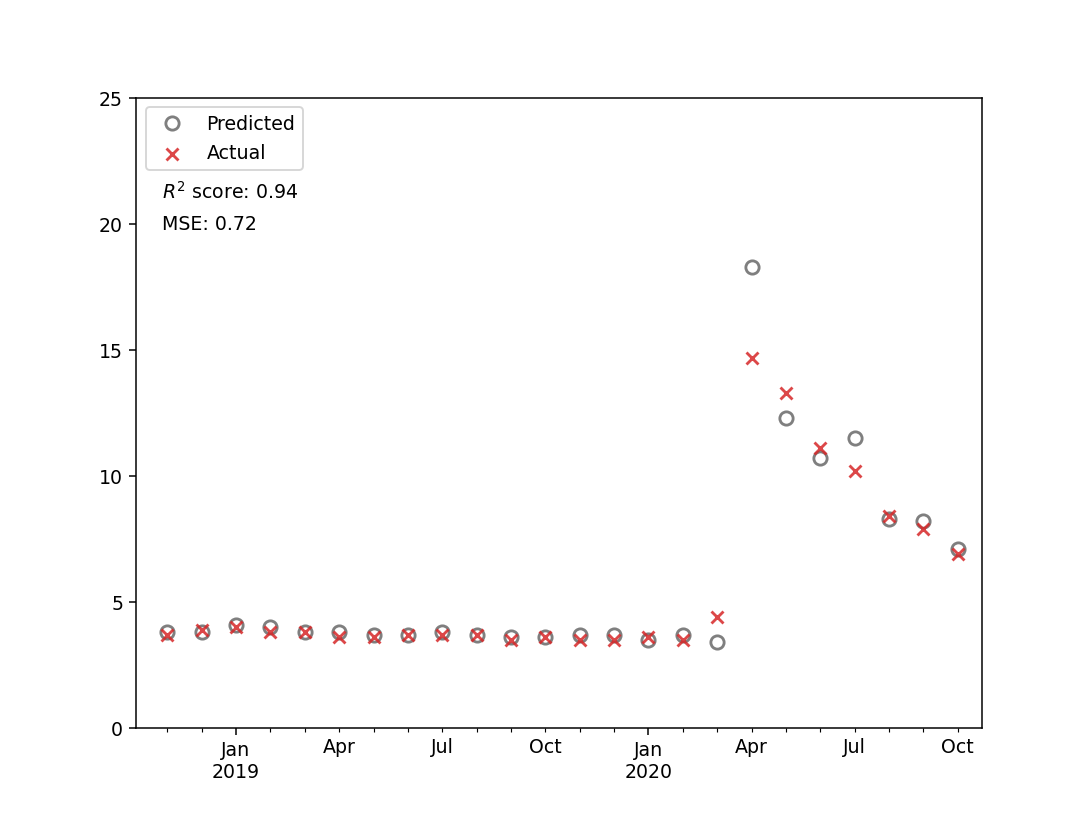

In [21]:
y_df = pd.DataFrame(y_pred.values(),index=pd.to_datetime(list(y_pred.keys()))+pd.DateOffset(days=+1)+pd.DateOffset(months=-1)
                    , columns=['Predicted','Actual'])

y_dummy = dill.load(open(unemp_path,'rb')).shift()
y_dummy.rename(columns={'unemployment_rate':'Dummy'}, inplace=True)
y_df = y_df.join(y_dummy)
y_df['Predicted'] = y_df['Predicted'].apply(lambda x: x[0])
y_df['Actual'] = y_df['Actual'].apply(lambda x: x[0])
y_df = y_df.iloc[-24:]


y_df.loc[:,['Predicted']].plot(marker='o', lw=0, markersize=7, legend=False, markeredgewidth=1.5,
                               markerfacecolor='None', figsize=(8,6), markeredgecolor='tab:gray')

plt.scatter(y_df.index, y_df['Actual'], marker='x', alpha=.85,
            facecolors='tab:red', zorder=9999, s=40, label='Actual')

ax=plt.gca()
plt.xlim(ax.get_xlim()[0]-0.9,ax.get_xlim()[-1]+0.7)
r2 = round(r2_score(y_true=y_df['Actual'], y_pred=y_df['Predicted']),2)
mse = round(mean_squared_error(y_true=y_df['Actual'], y_pred=y_df['Predicted']),2)
plt.text(0.03,0.84, r'$R^{2}$ score: '+f'{r2}', transform=ax.transAxes, ha='left')
plt.text(0.03,0.79, 'MSE: '+f'{mse}', transform=ax.transAxes, ha='left')
plt.legend(loc='upper left')
plt.ylim(0,25);


## Dummy Estimator

We just saw the model's $R^2$ and Mean Squared Error over the past 24 month, but how do we know these metrics are good enough? When it comes to model performance metrics, there is no magic threshold that defines whether a model is performing well. If $R^2$ is above zero, the model has done better than predicting the mean of `y_test` array at all times.

It is a good idea to introduce a dummy estimator as our baseline case and compare its $R^2$ and Mean Squared Error with our model. For this project, we'll define our dummy estimator as a model that assumes unemployment will remain the same as last month. In other words, our dummy estimator is one month out-of-phase. Our goal is to perform better than the dummy estimator. Performance of the Dummy Estimator is plotted below.

<IPython.core.display.Javascript object>


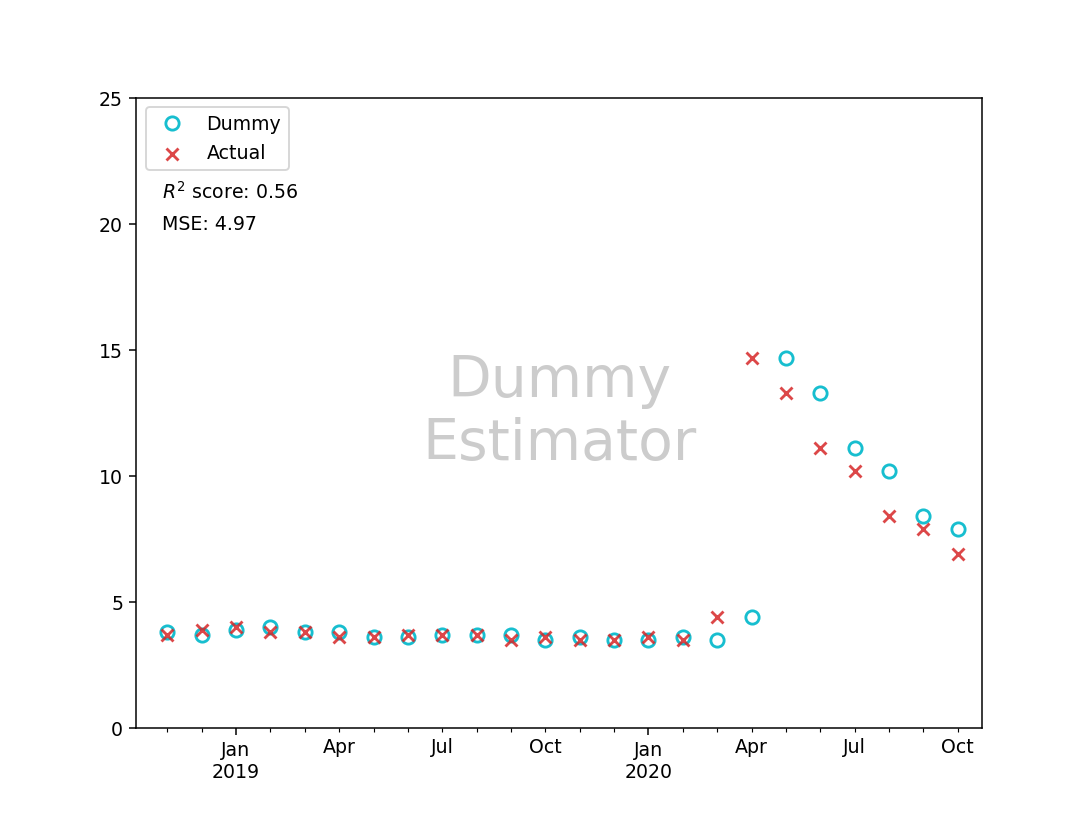

In [22]:
y_df.loc[:,['Dummy']].plot(marker='o', lw=0, markersize=7, legend=False, markeredgewidth=1.5,
                               markerfacecolor='None', figsize=(8,6), markeredgecolor='tab:cyan')
plt.scatter(y_df.index, y_df['Actual'], marker='x', alpha=.85,
            facecolors='tab:red', zorder=9999, s=40, label='Actual')

ax=plt.gca()
plt.xlim(ax.get_xlim()[0]-0.9,ax.get_xlim()[-1]+0.7)
r2 = round(r2_score(y_true=y_df['Actual'], y_pred=y_df['Dummy']),2)
mse = round(mean_squared_error(y_true=y_df['Actual'], y_pred=y_df['Dummy']),2)
plt.text(0.03,0.84, r'$R^{2}$ score: '+f'{r2}', transform=ax.transAxes, ha='left')
plt.text(0.03,0.79, 'MSE: '+f'{mse}', transform=ax.transAxes, ha='left')
plt.legend(loc='upper left')
plt.ylim(0,25)
plt.text(0.5,0.5, 'Dummy\nEstimator', transform=ax.transAxes, 
         alpha=.2, ha='center', va='center', size=30);

## Conclusion


Even though the dummy estimator appears to do well when the economy is stable, the Ridge Regression model 
beats the dummy estimator at an $R^2$ of 0.94 vs 0.56 and a Mean Squared Error of 0.72 vs 4.97 .


Copyright © 2020 Sina Amini. All rights reserved.